In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

/home/michael/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/michael/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

In [2]:
data = pd.read_csv('./data/processed_data_for_model.csv')

In [3]:
drop_hospitals = True

if drop_hospitals:
    selected_cols = []
    for col in list(data):
        if col[0:8] == 'hospital':
            pass
        else:
            selected_cols.append(col)
    
    data = data[selected_cols]

In [4]:
data.head()

,parity,prevcaes,noscans,pyrexia,meconium,apgar5,bmi,age,gest,analgesia_I,...,delivery_E,delivery_L,delivery_O,delivery_R,delivery_S,delivery_V,onset_E,onset_I,onset_N,onset_S
0,4.0,0.0,1.0,False,False,9.0,22,25,41,True,...,0,0,0,0,1,0,0,0,0,1
1,0.0,0.0,3.0,False,True,7.0,20,34,41,True,...,0,0,0,0,0,0,0,0,0,1
2,0.0,0.0,1.0,False,False,10.0,21,34,39,False,...,0,0,0,0,1,0,0,0,0,1
3,0.0,0.0,2.0,False,False,10.0,23,30,39,True,...,0,0,0,0,1,0,0,0,0,1
4,1.0,0.0,1.0,False,False,10.0,21,29,39,True,...,0,0,0,0,1,0,0,0,0,1


Balance data

In [5]:
mask = data['apgar5'] <7
pos_class = data[mask]

mask = data['apgar5'] >= 7
neg_class = data[mask].sample(len(pos_class))

data = pd.concat([neg_class, pos_class], axis=0).sample(frac=1.0, random_state=42)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

Split X and y

In [6]:
y = data['apgar5'] < 7
X = data.drop('apgar5', axis=1)

In [7]:
# Set up splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

5

In [8]:
# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []
importances = []

# Loop through the k-fold splits
counter = 0
for train_index, test_index in skf.split(X, y):
    counter += 1
    
    # Get X and Y train/test
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Fit model
    model = HistGradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Get importances
    #importances.append(model.feature_importances_)

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    y_class = model.predict(X_test)
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {counter}, accuracy: {accuracy:0.3f}')

Run 1, accuracy: 0.722
Run 2, accuracy: 0.720
Run 3, accuracy: 0.722
Run 4, accuracy: 0.721
Run 5, accuracy: 0.716


In [9]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(number_of_splits):
    # Get fpr, tpr and thresholds foir each k-fold from scikit-learn's ROC method
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    # Use scikit-learn's method for calulcating auc
    roc_auc = auc(fpr, tpr)
    # Store results
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    # Print auc result
    print (f'Run {i} AUC {roc_auc:0.4f}')

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.7872
Run 1 AUC 0.7936
Run 2 AUC 0.7895
Run 3 AUC 0.7871
Run 4 AUC 0.7858

Mean AUC: 0.7886
SD AUC: 0.0027


SHAP (to all data)

In [10]:
model = HistGradientBoostingClassifier()
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X)
shap_values = explainer.shap_values(X)
shap_values_extended[0]

.values =
array([-1.53432311e-01,  1.99428483e-02, -1.86423436e-01, -1.16530430e-02,
       -1.38357898e-01,  2.41811187e-03,  1.09546053e-01,  1.03790129e+00,
        4.66235229e-03, -9.28313677e-02, -3.64338943e-02, -3.76989278e-01,
        1.93430899e-03, -3.97819117e-03,  9.39787718e-04, -4.69289759e-03,
        7.55238251e-04, -4.44482847e-02,  1.50381021e-02, -1.12827665e-02,
        6.95480365e-02, -1.68680873e-01, -1.91643140e-01, -5.01741356e-02,
       -2.29884746e-02, -2.18119554e-03, -9.17700594e-02,  2.93743007e-03,
        3.42452248e-03,  2.34502067e-03, -4.82321267e-03, -6.15813965e-02,
       -1.99131829e-03,  0.00000000e+00,  8.76327401e-03, -9.28899691e-03,
       -5.62937570e-02])

.base_values =
array([0.11933671])

.data =
array([2.0, 0.0, 1.0, False, False, 26, 24, 34, False, False, True, False,
       False, False, False, False, False, False, False, False, True, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], dtype=object)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


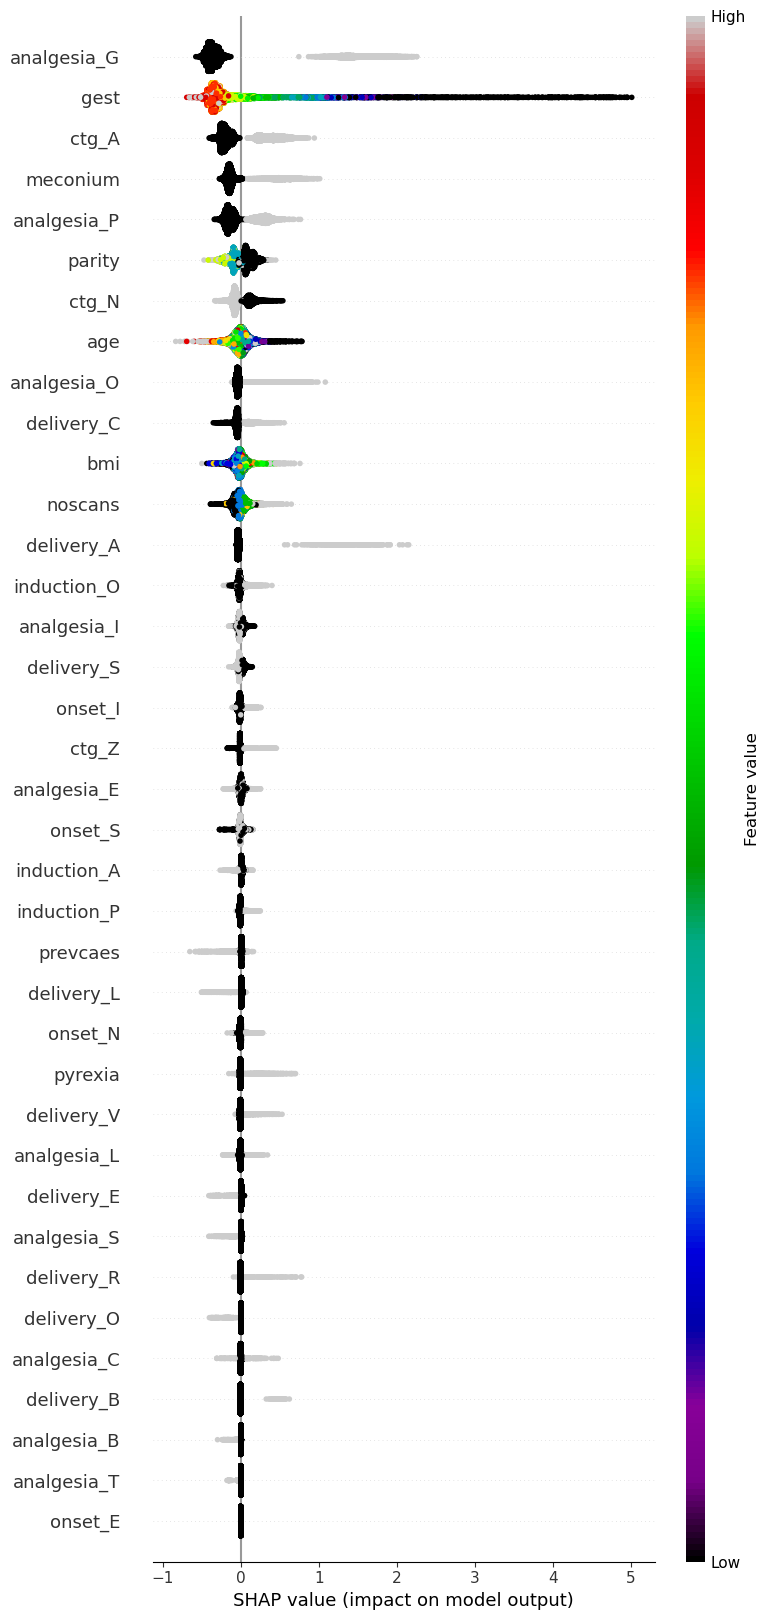

In [11]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X,
                  feature_names=list(X),
                  max_display=60,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

plt.show()

In [12]:
df = pd.DataFrame(index=list(X))
df['feature_index'] = np.arange(len(list(X)))
df['mean_shap'] = np.mean(shap_values, axis=0)
df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df.sort_values('mean_abs_shap', ascending=False, inplace=True)

top_shap = list(df.index)
df.head(10)

,feature_index,mean_shap,mean_abs_shap
analgesia_G,11,-0.001723,0.582178
gest,7,0.014581,0.482992
ctg_A,21,0.000210,0.263822
meconium,4,-0.001802,0.220480
analgesia_P,9,-0.001809,0.188729
parity,0,0.005161,0.108832
ctg_N,22,0.007856,0.103552
age,6,0.001025,0.091887
analgesia_O,17,-0.005668,0.072583
delivery_C,26,-0.014478,0.072572


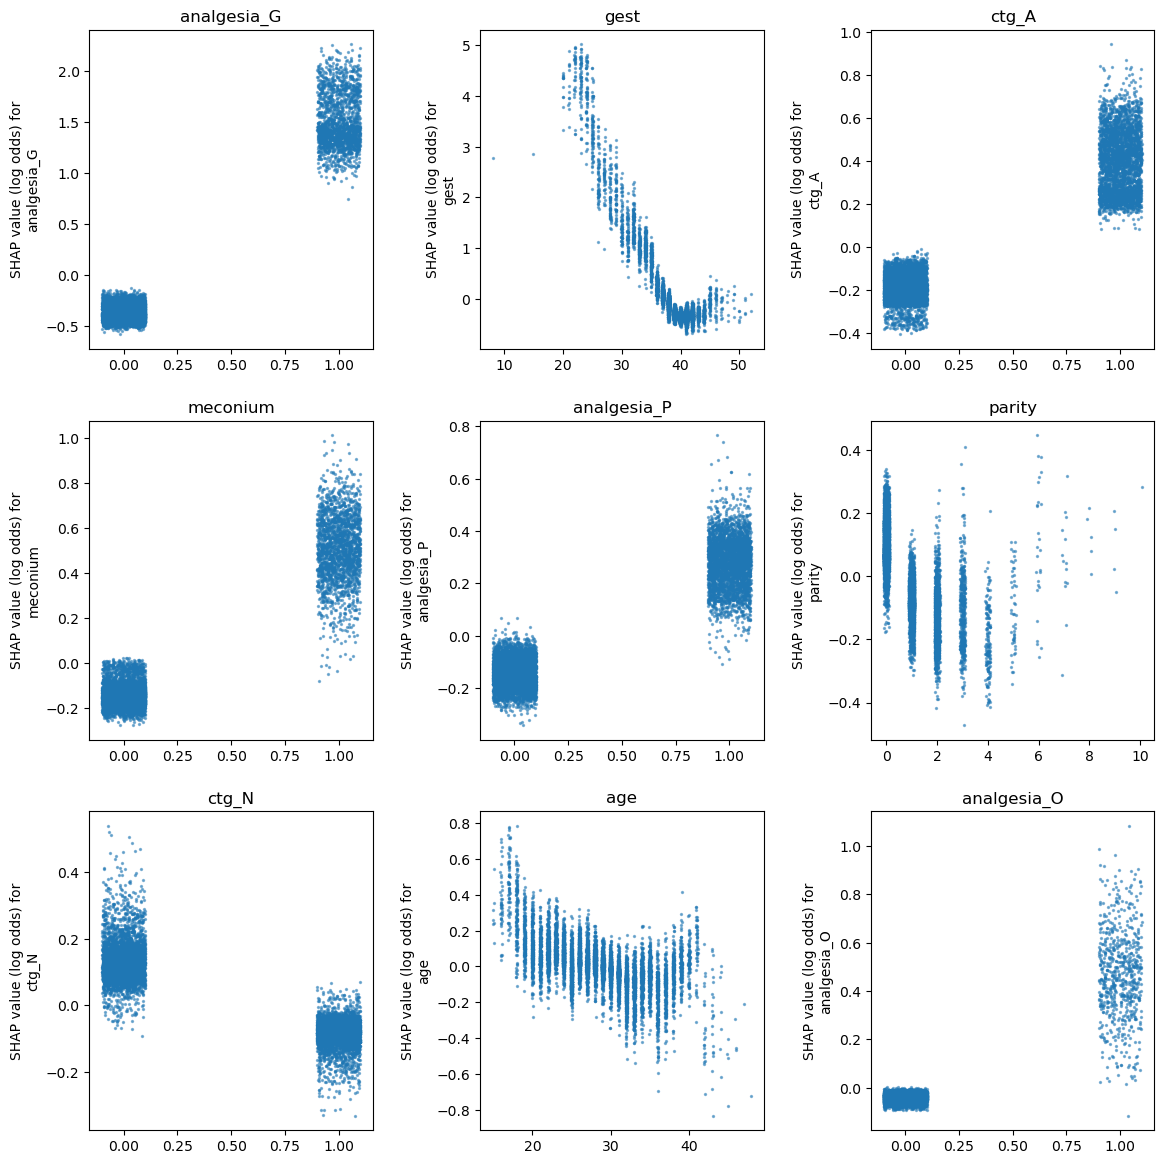

In [13]:
feat_to_show = top_shap[0:9]

fig = plt.figure(figsize=(12,12))
for n, feat in enumerate(feat_to_show):
    feat_index = int(df.loc[feat]['feature_index']) 
    ax = fig.add_subplot(3,3,n+1)

    shap_data = shap_values_extended[:].values[:,feat_index]
    feature_data = shap_values_extended[:].data[:,feat_index]

    jitter = -0.1 + (np.random.rand(len(feature_data))*0.2)

    ax.scatter(feature_data + jitter, shap_data, alpha=0.5, s=2)
  
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
plt.savefig('./output/shap_1.jpg', dpi=300)

plt.show()
